In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from sklearn import datasets
from scipy.spatial import ConvexHull
import numpy as np
import random
import math

In [2]:
# config
dtset_name = ['iris', 'wine', 'breast_cancer'][2] # sklearn datasets
mst_fn_name = ['euclidian_distance', 'angle'][1] # mst cost function
output_dir = 'output'

In [3]:
original_data = getattr(datasets, 'load_' + dtset_name)()
N = len(original_data.data)
print('Total points:', N)

Total points: 569


In [4]:
X = original_data.data
y = original_data.target
X_features = original_data.feature_names
y_targets = original_data.target_names

In [5]:
def random_colors(size):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for j in range(size)]

def plot_map(dt, label):
    data = dt.copy()
    plt.clf()
    X = []
    Y = []
    color = []
    uniq_labels = np.unique(label)
    colors = random_colors(len(uniq_labels))
    # print(colors)
    for dt in data:
        for i in dt:
            X.append(dt[i][0])
            Y.append(dt[i][1])
            color.append(colors[label[i]])

    patches = []
    for i in range(len(uniq_labels)):
        pcolor = colors[i]
        label = i
        patch = mpatches.Patch(color=pcolor, label=label)
        patches.append(patch)
    plt.legend(handles=patches)
    plt.scatter(X, Y, c=color)

In [6]:
# distance and angle function
def euclidian_distance(pt1, pt2):
    point1 = pt1
    point2 = pt2
    diff = point1 - point2
    return np.sqrt(np.dot(diff, diff))

def angle(pt1, pt2):
    point1 = pt1.copy()
    point2 = pt2.copy()
    inner = np.inner(point1, point2)
    norm = np.linalg.norm(point1) * np.linalg.norm(point2)
    cos = inner / norm
    rad =  np.arccos(np.clip(cos, -1.0, 1.0))
    return np.rad2deg(rad)

mst_fn = locals()[mst_fn_name]

In [7]:
def cost_matrix(dt, cost_fn):
    data = dt.copy()
    h, _ = data.shape
    # print(h)
    cost_matrix = np.zeros((h, h))
    for x in range(h):
        for y in range(x, h):
            # dist = euclidian_distance(data.iloc[x], data.iloc[y])
            dist = cost_fn(data[x], data[y])
            cost_matrix[x][y], cost_matrix[y][x] = dist, dist
    return cost_matrix

def mst(dt):
    data = dt.copy()
    h, _ = data.shape
    INF = 9999999
    cm = cost_matrix(data, mst_fn)
    # print(cm)
    snode = np.zeros(h)
    nedges = 0
    snode[0] = True

    palist = []
    pblist = []
    cost = []
    while nedges < h - 1:
        min = INF
        a, b = 0, 0
        for m in range(h):
            if snode[m]:
                for n in range(h):
                    if (not snode[n]) and cm[m][n]:
                        # not in selected and there is an edge
                        if min > cm[m][n]:
                            min = cm[m][n]
                            a = m
                            b = n
        # print(str(a) + "-" + str(b) + ":" + str(cm[a][b]))
        palist.append(a)
        pblist.append(b)
        cost.append(cm[a][b])
        snode[b] = True
        nedges += 1
    srtd = sorted(zip(cost, zip(palist, pblist)))
    edges = [st[1] for st in srtd]
    cst = [st[0] for st in srtd]
    return edges, cst, srtd

In [8]:
# rotation function
def rotation_fn(pt, deg):
    point = pt.copy()
    x = point[0]
    y = point[1]
    rad = math.radians(deg)
    cos = np.cos(rad)
    sin = np.sin(rad)
    x_prime = x * cos - y * sin
    y_prime = x * sin + y * cos
    return [x_prime, y_prime]

def rotate(pts, deg):
    arr_point = pts.copy()
    center = np.min(arr_point, axis=0) / 2
    for i in range(len(arr_point)):
        arr_point[i] -= center
    for i in range(len(arr_point)):
        arr_point[i] = rotation_fn(arr_point[i], deg)
    for i in range(len(arr_point)):
        arr_point[i] += center
    return arr_point

# main driver functions
def count_weight(pts):
    points = pts.copy()
    weight = 0
    for point in points:
        y = point[1]
        weight += y
    return weight

def make_convex(pts, reverse):
    arr_point = pts.copy()
    all_x_zero = True
    for i in arr_point:
        if i[0] != 0:
            all_x_zero = False
    hull = arr_point.copy()
    if not all_x_zero:
        hull = ConvexHull(arr_point.copy()).points
    threshold_weight = None
    final_points = None
    agl = None

    for i in range(360):
        temp_points = rotate(hull, i)
        weight = count_weight(temp_points)
        # print(weight)
        if threshold_weight is None:
            threshold_weight = weight
            # final_points = temp_points
            agl = i
        elif not reverse and weight > threshold_weight:
            threshold_weight = weight
            # final_points = temp_points
            agl = i
        elif reverse and weight < threshold_weight:
            threshold_weight = weight
            # final_points = temp_points
            agl = i

    return rotate(arr_point, i), agl

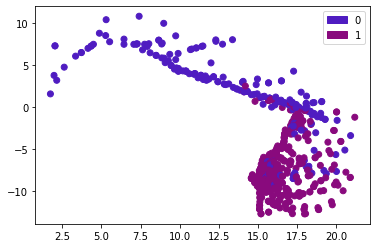

In [9]:
def get_component(cps, point):
    components = cps.copy()
    for i in range(len(components)):
        if point in components[i]:
            return i;

def rotation(cp, convex = True):
    component = cp.copy()
    # TODO - rotate component along origin:::: type(component) = dict
    ids = []
    points = []
    for i in component:
        ids.append(i)
        points.append(component[i])
    points, agl = make_convex(np.array(points), convex)

    count = 0
    for id in ids:
        component[id] = points[count]
        count += 1
    return component

def align_hull_wrapper( cp, p_index, convex = True):
    # center the component to origin on point
    component = cp.copy()
    point = component[p_index].copy()
    for i in component:
        component[i] = [component[i][0] - point[0], component[i][1] - point[1]]

    if len(component) == 1:
        pass
    elif len(component) == 2:
        keys = list(component.keys())
        values = np.array(list(component.values()))
        dist = euclidian_distance(values[0][0].copy(), values[0][1].copy()).astype('float64')
        component[keys[0]] = [0.0,0.0]
        component[keys[1]] = [dist, 0.0]
    elif convex:
        # for valley
        component = rotation(component.copy(), convex)
        pass
    else:
        # for hill
        component = rotation(component.copy(), convex)
        pass

    # get back the original position
    for i in component:
        component[i] = [component[i][0] + point[0], component[i][1] + point[1]]
    # print(component)
    return component

def join_r2(cpa, cpb, pa_index, pb_index, el):
    ca = cpa.copy()
    cb = cpb.copy()
    # align hulls
    ca = align_hull_wrapper(ca, pa_index)
    cb = align_hull_wrapper(cb, pb_index, False)

    # points
    pa_point = ca[pa_index].copy()
    pb_point = cb[pb_index].copy()

    # take pa_point to required pb_point
    pa_point[1] += el

    diff_x, diff_y = pa_point[0] - pb_point[0], pa_point[1] - pb_point[1]

    for i in cb:
        cb[i][0] += diff_x
        cb[i][1] += diff_y
    return ca, cb;

def driver(dt):
    data = dt.copy()
    edges, cst, _ = mst(data)
    # P_prime = [[0,0] for i in range(N)]
    C_set = [{i: [0,0]} for i in range(N)]
    for i in range (N-1):
        # points
        pa_index, pb_index = edges[i]
        edge_len = cst[i].copy()

        # components
        ca_index, cb_index = get_component(C_set, pa_index), get_component(C_set, pb_index)
        # comp_a = C_set[ca_index]
        # comp_b = C_set[cb_index]

        # plot in R2-plane
        comp_a, comp_b = join_r2(C_set[ca_index], C_set[cb_index], pa_index, pb_index, edge_len)

        C_set[ca_index] = comp_a
        C_set[cb_index] = comp_b

        C_set[ca_index].update(C_set[cb_index])
        del C_set[cb_index]
    return C_set

# ani = FuncAnimation(plt.gcf(), driver, fargs=(X, y), interval=10)
points = driver(X)
plot_map(points, y)
plt.savefig(output_dir + '/' + dtset_name + '_' + mst_fn_name + '_1.png')
plt.show()

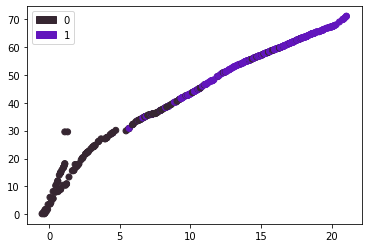

In [10]:
projected_data = []
for i in range(len(X)):
    projected_data.append(points[0][i])
ppoints = driver(np.array(projected_data))
plot_map(ppoints, y)
plt.savefig(output_dir + '/' + dtset_name + '_' + mst_fn_name + '_2.png')
plt.show()